# Read SUMMA output

In [2]:
# netcdf/numpy/xray/stats
import numpy as np
from datetime import datetime, timedelta
import pandas as pd
import xarray as xr
from scipy.stats.stats import pearsonr

# OS interaction
import sys, pickle, os

# import plotting
import seaborn as sns
import matplotlib
from matplotlib.pyplot import subplots
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.basemap import Basemap
import kgraph

# Offline Turbulence Package
import turbpy

# Customize
sns.set_style("whitegrid")
sns.set_context('talk')
%matplotlib inline

In [3]:
# --------------------------------------------------------------------------------------------------------------------
# Directory Lists
# Unix
if 'linux' in sys.platform:
    dirPre = '/home/lapok/gdrive/'
# Mac
elif 'darwin' in sys.platform:
    dirPre = '/Users/karllapo/gdrive/'

dirProj = dirPre + 'SnowHydrology/proj/ModTsfc/'
dirPrint = dirProj + 'Graphics'
dirData = dirProj + 'data'

## Functions to quickly evaluate all model output

In [4]:
def evalDiurnalTs(ax, dsDict, obs, labels, ls, lcolor):
    # Tsurf scatter plot
    hours = np.arange(0, 24)
    for ex in sorted(dsDict.keys()):
        ax.plot(hours, dsDict[ex].scalarSurfaceTemp.groupby('time.hour').mean(dim='time') - 273.15,
                label=labels[ex],
                linestyle=ls[ex],
                color=lcolor[ex])
    ax.plot(hours, obs.Tsrf.groupby('time.hour').mean(dim='time'), 'k', linewidth=3, label='Obs.')
    ax.plot([0, 23], [0, 0], color='.5')
    ax.set_xlim(0, 23)
    ax.set_ylim(-12, 0)
    ax.set_xlabel('Hour of Day')
    ax.set_ylabel('T ($C^{\circ}$)')
    ax.legend(loc='best')

## Forcing data

In [5]:
os.chdir(dirData)
CDP = xr.open_dataset('CDP.ModTsfc.nc')

# --------------------------------------------------------------------------------------------
# Select only the model forcing period
CDP = CDP.loc[dict(time = slice(datetime(2005, 10, 1), datetime(2006, 9, 1)))]

RiBulk,_,_ = turbpy.bulkRichardson(CDP.Tair + 273.15, CDP.Tsrf + 273.15, CDP.WIND, 1.5 - CDP.snowDepth)
CDP['RiBulk'] = RiBulk

//anaconda/lib/python3.5/site-packages/xarray/core/variable.py:1130: RuntimeWarning: divide by zero encountered in true_divide
  if not reflexive
//anaconda/lib/python3.5/site-packages/xarray/core/variable.py:1130: RuntimeWarning: invalid value encountered in true_divide
  if not reflexive


## Model output

## Check out the layer runs

In [6]:
os.chdir('/Users/karllapo/gdrive/SnowHydrology/proj/ModTsfc/summa/ModTsfc_summa/output/layers/CDP/')
layerThin = xr.open_dataset('layerThick_2005-2006_thinLayer_1.nc')
layerThick = xr.open_dataset('layerThin_2005-2006_thickLayer_1.nc')
jrdn1991 = xr.open_dataset('jrdn1991_2005-2006_jrdn1991_1.nc')
clm2010 = xr.open_dataset('CLM_2010_2005-2006_CLM_2010_1.nc')

layerExp = {'layerThin': layerThin,
            'layerThick': layerThick,
            'jrdn1991': jrdn1991,
            'clm2010': clm2010
           }
layerExpLabel = {'layerThin': 'UEB-like',
                 'layerThick': 'VIC-like',
                 'clm2010': 'CLM-like',
                 'jrdn1991': 'SNTHERM-like',
                }

layerExpLineStyle = {'layerThin': '-',
                     'layerThick': '-',
                     'clm2010': '-',
                     'jrdn1991': '-',
                }

color = kgraph.SRON(4)
layerExpColor = {'layerThin': color[0],
                 'layerThick': color[1],
                 'clm2010': color[2],
                 'jrdn1991': color[3],
                }

# There is some trouble reading in the summa netcdf time, so let's just force this to be correct
for l in layerExp:
    layerExp[l]['time'] = CDP.time.values

## Check out the thermal conductivity runs

In [7]:
os.chdir('/Users/karllapo/gdrive/SnowHydrology/proj/ModTsfc/summa/ModTsfc_summa/output/thermalCond/CDP/')

thCond = {}
thCondLabel = {}
thCondLineStyle = {}
thCondColor = {}

arrayExpID = ['tyen1965', 'melr1977', 'jrdn1991', 'smnv2000']
expIDAppend = ['Mid', 'Low', 'High']
expIDAppendLineStyle = {'Mid': '-',
                        'Low': '--',
                        'High': ':'}
color = kgraph.SRON(4)

for n, expID in enumerate(arrayExpID):
    for append in expIDAppend:
        expName = expID + append
        thCond[expName] = xr.open_dataset(expName + '_2005-2006_' + expName + '_1.nc')
#         thCondLabel[expName] = expID + ' ' + append + ' conductivity'
        thCondLabel[expName] = ''

        thCondLineStyle[expName] = expIDAppendLineStyle[append]
        
        thCondColor[expName] = color[n]
    
# There is some trouble reading in the summa netcdf time, so let's just force this to be correct
for t in thCond:
    thCond[t]['time'] = CDP.time.values

## Check out the longwave bias runs

In [8]:
os.chdir('/Users/karllapo/gdrive/SnowHydrology/proj/ModTsfc/summa/ModTsfc_summa/output/longwaveBias/CDP/')

biasLW = {}
arrayExpID = ['lowLW', 'obsLW', 'highLW']
color = kgraph.SRON(3)

for expID in arrayExpID:
    biasLW[expID] = xr.open_dataset(expID + '_2005-2006_' + expID + '_1.nc')

biasLWLabel = {'lowLW': '-20 Wm-2 bias',
               'obsLW': '0 Wm-2 bias', 
               'highLW': '+20Wm-2 bias'
              }
biasLWColor = {'lowLW': color[0],
               'obsLW': color[1], 
               'highLW': color[2]
              }
biasLWLineStyle = {'lowLW': '-',
                   'obsLW': '-', 
                   'highLW': '-'
                  }

# There is some trouble reading in the summa netcdf time, so let's just force this to be correct
for b in biasLW:
    biasLW[b]['time'] = CDP.time.values

##  Check out the turbulence stability runs

In [9]:
os.chdir('/Users/karllapo/gdrive/SnowHydrology/proj/ModTsfc/summa/ModTsfc_summa/output/stability/CDP/')

stab = {}
stabLabel = {}
stabLineStyle = {}
stabColor = {}
expIDAppend = ['Low', 'Mid', 'High']
arrayExpID = ['standard', 'louisinv', 'mahrtexp']
expIDLineStyle = {'Mid': '-',
                  'Low': '--',
                  'High': ':'}
color = kgraph.SRON(3)

for n, expID in enumerate(arrayExpID):
    for append in expIDAppend:
        expName = expID + append
        stab[expName] = xr.open_dataset(expName + '_2005-2006_' + expName + '_1.nc')
        stabLabel[expName] = ''
#         stabLabel[expName] = expID + ' ' + append + ' z0'
        stabLineStyle[expName] = expIDLineStyle[append]
        stabColor[expName] = color[n]
        
# There is some trouble reading in the summa netcdf time, so let's just force this to be correct
for b in stab:
    stab[b]['time'] = CDP.time.values

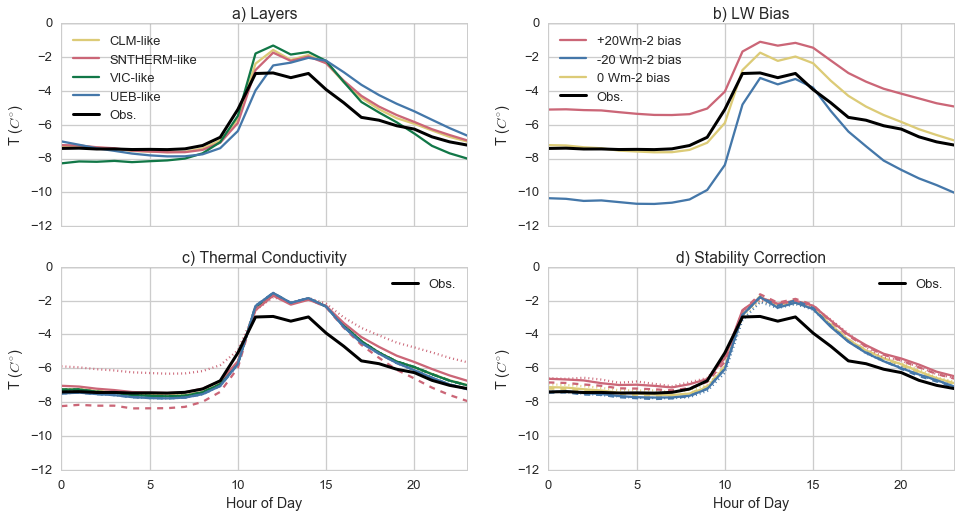

In [10]:
fig, axes = plt.subplots(2, 2, figsize= (16, 8))
axes = axes.flatten()

ax = axes[0]
tempDS = {}
for n in layerExp:
    tempDS[n] = layerExp[n]
    tempDS[n]['scalarSurfaceTemp'] = layerExp[n]['scalarSurfaceTemp'].where((CDP.SP == 1)
                                                                            & (tempDS[n]['scalarSWE'] > 0))
evalDiurnalTs(ax, tempDS, CDP, layerExpLabel, layerExpLineStyle, layerExpColor)
ax.set_title('a) Layers')
ax.set_xticklabels([])
ax.set_xlabel('')

ax = axes[1]
tempDS = {}
for n in biasLW:
    tempDS[n] = biasLW[n]
    tempDS[n]['scalarSurfaceTemp'] = biasLW[n]['scalarSurfaceTemp'].where((CDP.SP == 1)
                                                                            & (tempDS[n]['scalarSWE'] > 0))
evalDiurnalTs(ax, tempDS, CDP,  biasLWLabel, biasLWLineStyle, biasLWColor)
ax.set_title('b) LW Bias')
ax.set_xticklabels([])
ax.set_xlabel('')

ax = axes[2]
tempDS = {}
for n in thCond:
    tempDS[n] = thCond[n]
    tempDS[n]['scalarSurfaceTemp'] = thCond[n]['scalarSurfaceTemp'].where((CDP.SP == 1)
                                                                         & (tempDS[n]['scalarSWE'] > 0))
evalDiurnalTs(ax, tempDS, CDP, thCondLabel, thCondLineStyle, thCondColor)
ax.set_title('c) Thermal Conductivity')

ax = axes[3]
tempDS = {}
for n in stab:
    tempDS[n] = stab[n]
    tempDS[n]['scalarSurfaceTemp'] = stab[n]['scalarSurfaceTemp'].where((CDP.SP == 1)
                                                                            & (tempDS[n]['scalarSWE'] > 0))
evalDiurnalTs(ax, tempDS, CDP, stabLabel, stabLineStyle, stabColor)
ax.set_title('d) Stability Correction')

os.chdir(dirPrint)
fig.savefig('ModTsfc.WSC17.DiurnalTs_All.pdf')
fig.savefig('ModTsfc.WSC17.DiurnalTs_All.png')

In [11]:
def evalDiurnalTs_Criteria(ax, dsDict, obs, criteria, labels, ls, lcolor):
    # Tsurf scatter plot
    hours = np.arange(0, 24)
    for ex in sorted(dsDict.keys()):
        ds = dsDict[ex].scalarSurfaceTemp.where(criteria)
        ds_obs = obs.Tsrf.where(criteria)
        ax.plot(hours, ds.groupby('time.hour').mean(dim='time') - 273.15,
                label=labels[ex],
                linestyle=ls[ex],
                color=lcolor[ex])
    ax.plot(hours, ds_obs.groupby('time.hour').mean(dim='time'), 'k', linewidth=3, label='Obs.')
    ax.plot([0, 23], [0, 0], color='.5')
    ax.set_xlim(0, 23)
    ax.set_ylim(-15, 0)
    ax.set_xlabel('Hour of Day')
    ax.set_ylabel('T ($C^{\circ}$)')
    ax.legend(loc='best')

//anaconda/lib/python3.5/site-packages/xarray/core/variable.py:1130: RuntimeWarning: invalid value encountered in greater
  if not reflexive
//anaconda/lib/python3.5/site-packages/xarray/core/variable.py:1130: RuntimeWarning: invalid value encountered in less
  if not reflexive


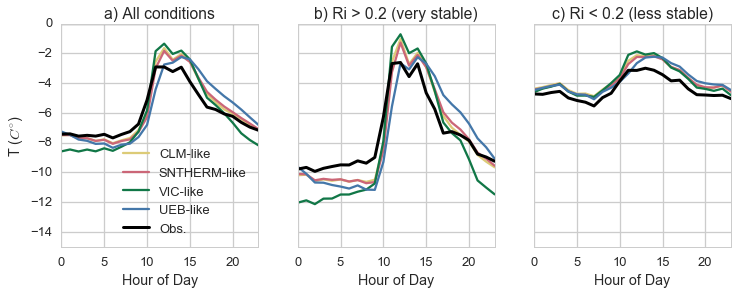

In [12]:
# --------------------------------------------------------------------------------------------------------------------
# Layers
fig, axes = plt.subplots(1, 3, figsize= (12, 4))
axes = axes.flatten()
tempDS = {}
for n in layerExp:
    tempDS[n] = layerExp[n]
    tempDS[n]['scalarSurfaceTemp'] = layerExp[n]['scalarSurfaceTemp'].where((CDP.SP == 1)
                                                                            & (tempDS[n]['scalarSWE'] > 0))

ax = axes[0]
criteria = CDP.RiBulk > 0.
evalDiurnalTs_Criteria(ax, tempDS, CDP, criteria, layerExpLabel, layerExpLineStyle, layerExpColor)
ax.set_title('a) All conditions')

ax = axes[1]
criteria = CDP.RiBulk > 0.2
evalDiurnalTs_Criteria(ax, tempDS, CDP, criteria, layerExpLabel, layerExpLineStyle, layerExpColor)
ax.set_yticklabels([])
ax.set_ylabel('')
ax.legend_.remove()
ax.set_title('b) Ri > 0.2 (very stable)')

ax = axes[2]
criteria = CDP.RiBulk < 0.2
evalDiurnalTs_Criteria(ax, tempDS, CDP, criteria, layerExpLabel, layerExpLineStyle, layerExpColor)
ax.set_yticklabels([])
ax.set_ylabel('')
ax.legend_.remove()
ax.set_title('c) Ri < 0.2 (less stable)')

os.chdir(dirPrint)
fig.savefig('ModTsfc.WSC17.DiurnalTs_Layers_Stability.pdf')

//anaconda/lib/python3.5/site-packages/xarray/core/variable.py:1130: RuntimeWarning: invalid value encountered in greater
  if not reflexive
//anaconda/lib/python3.5/site-packages/xarray/core/variable.py:1130: RuntimeWarning: invalid value encountered in less
  if not reflexive


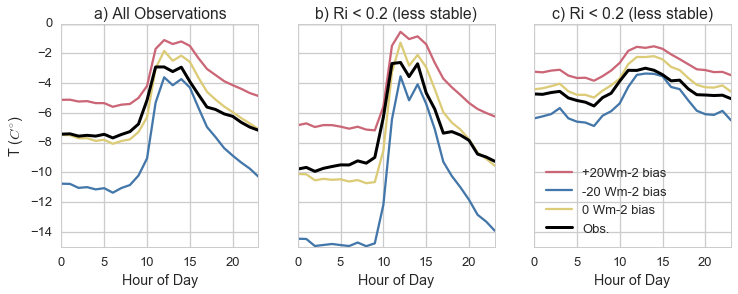

In [13]:
# --------------------------------------------------------------------------------------------------------------------
# Longwave bias
fig, axes = plt.subplots(1, 3, figsize= (12, 4))
axes = axes.flatten()
tempDS = {}
for n in biasLW:
    tempDS[n] = biasLW[n]
    tempDS[n]['scalarSurfaceTemp'] = biasLW[n]['scalarSurfaceTemp'].where((CDP.SP == 1)
                                                                            & (tempDS[n]['scalarSWE'] > 0))

ax = axes[0]
criteria = CDP.RiBulk > 0.
evalDiurnalTs_Criteria(ax, tempDS, CDP, criteria,  biasLWLabel, biasLWLineStyle, biasLWColor)
ax.legend_.remove()
ax.set_title('a) All Observations')

ax = axes[1]
criteria = CDP.RiBulk > 0.2
evalDiurnalTs_Criteria(ax, tempDS, CDP, criteria,  biasLWLabel, biasLWLineStyle, biasLWColor)
ax.set_yticklabels([])
ax.set_ylabel('')
ax.legend_.remove()
ax.set_title('b) Ri < 0.2 (less stable)')

ax = axes[2]
criteria = CDP.RiBulk < 0.2
evalDiurnalTs_Criteria(ax, tempDS, CDP, criteria,  biasLWLabel, biasLWLineStyle, biasLWColor)
ax.set_yticklabels([])
ax.set_ylabel('')
ax.set_title('c) Ri < 0.2 (less stable)')

os.chdir(dirPrint)
fig.savefig('ModTsfc.WSC17.biasLW_Layers_Stability.pdf')

//anaconda/lib/python3.5/site-packages/xarray/core/variable.py:1130: RuntimeWarning: invalid value encountered in greater
  if not reflexive
//anaconda/lib/python3.5/site-packages/xarray/core/variable.py:1130: RuntimeWarning: invalid value encountered in less
  if not reflexive


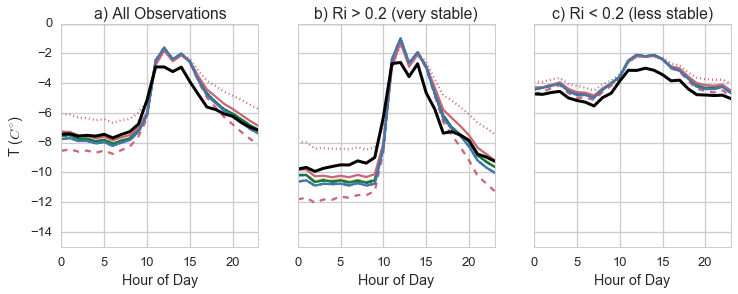

In [14]:
# --------------------------------------------------------------------------------------------------------------------
# Thermal Conductivity
fig, axes = plt.subplots(1, 3, figsize= (12, 4))
axes = axes.flatten()
tempDS = {}
for n in thCond:
    tempDS[n] = thCond[n]
    tempDS[n]['scalarSurfaceTemp'] = thCond[n]['scalarSurfaceTemp'].where((CDP.SP == 1)
                                                                         & (tempDS[n]['scalarSWE'] > 0))

ax = axes[0]
criteria = CDP.RiBulk > 0.
evalDiurnalTs_Criteria(ax, tempDS, CDP, criteria, thCondLabel, thCondLineStyle, thCondColor)
ax.legend_.remove()
ax.set_title('a) All Observations')

ax = axes[1]
criteria = CDP.RiBulk > 0.2
evalDiurnalTs_Criteria(ax, tempDS, CDP, criteria, thCondLabel, thCondLineStyle, thCondColor)
ax.set_yticklabels([])
ax.set_ylabel('')
ax.legend_.remove()
ax.set_title('b) Ri > 0.2 (very stable)')

ax = axes[2]
criteria = CDP.RiBulk < 0.2
evalDiurnalTs_Criteria(ax, tempDS, CDP, criteria, thCondLabel, thCondLineStyle, thCondColor)
ax.set_yticklabels([])
ax.set_ylabel('')
ax.legend_.remove()
ax.set_title('c) Ri < 0.2 (less stable)')

os.chdir(dirPrint)
fig.savefig('ModTsfc.WSC17.thermalConductivity_Layers_Stability.pdf')

//anaconda/lib/python3.5/site-packages/xarray/core/variable.py:1130: RuntimeWarning: invalid value encountered in greater
  if not reflexive
//anaconda/lib/python3.5/site-packages/xarray/core/variable.py:1130: RuntimeWarning: invalid value encountered in less
  if not reflexive


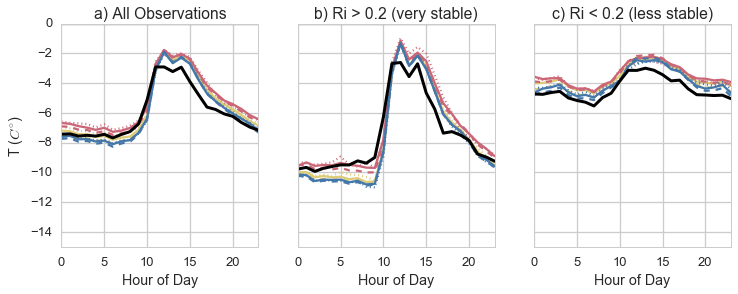

In [15]:
# --------------------------------------------------------------------------------------------------------------------
# Stability
# evalDiurnalTs_Criteria(ax, tempDS, CDP, criteria, stabLabel, stabLineStyle, stabColor)

fig, axes = plt.subplots(1, 3, figsize= (12, 4))
axes = axes.flatten()
tempDS = {}
for n in stab:
    tempDS[n] = stab[n]
    tempDS[n]['scalarSurfaceTemp'] = stab[n]['scalarSurfaceTemp'].where((CDP.SP == 1)
                                                                            & (tempDS[n]['scalarSWE'] > 0))

ax = axes[0]
criteria = CDP.RiBulk > 0.
evalDiurnalTs_Criteria(ax, tempDS, CDP, criteria, stabLabel, stabLineStyle, stabColor)
ax.legend_.remove()
ax.set_title('a) All Observations')

ax = axes[1]
criteria = CDP.RiBulk > 0.2
evalDiurnalTs_Criteria(ax, tempDS, CDP, criteria, stabLabel, stabLineStyle, stabColor)
ax.set_yticklabels([])
ax.set_ylabel('')
ax.legend_.remove()
ax.set_title('b) Ri > 0.2 (very stable)')

ax = axes[2]
criteria = CDP.RiBulk < 0.2
evalDiurnalTs_Criteria(ax, tempDS, CDP, criteria, stabLabel, stabLineStyle, stabColor)
ax.set_yticklabels([])
ax.set_ylabel('')
ax.legend_.remove()
ax.set_title('c) Ri < 0.2 (less stable)')

os.chdir(dirPrint)
fig.savefig('ModTsfc.WSC17.Stability_Layers_Stability.pdf')

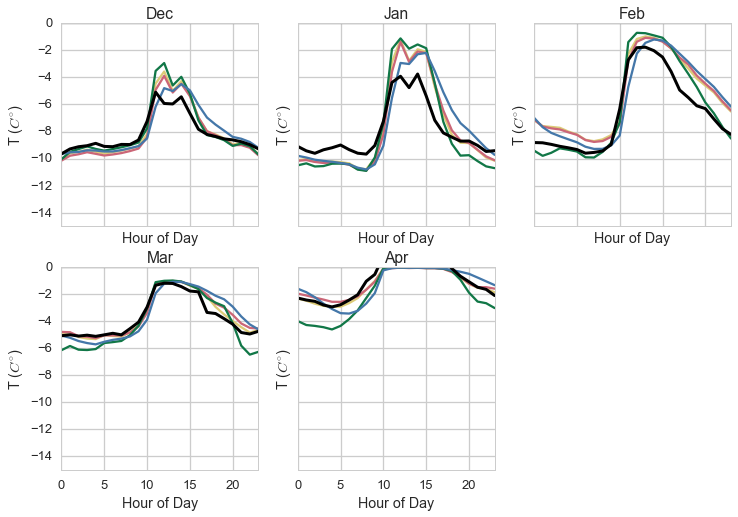

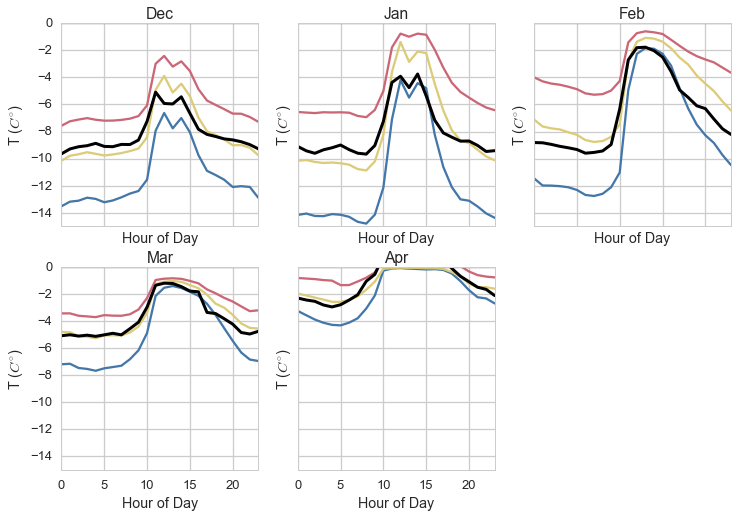

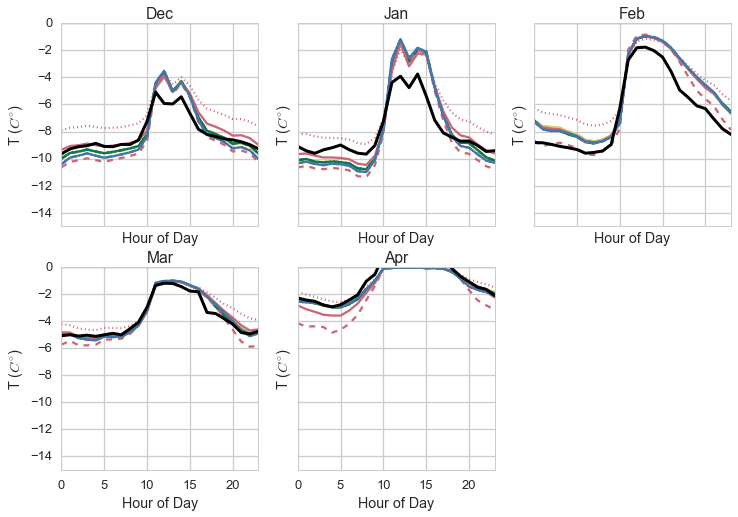

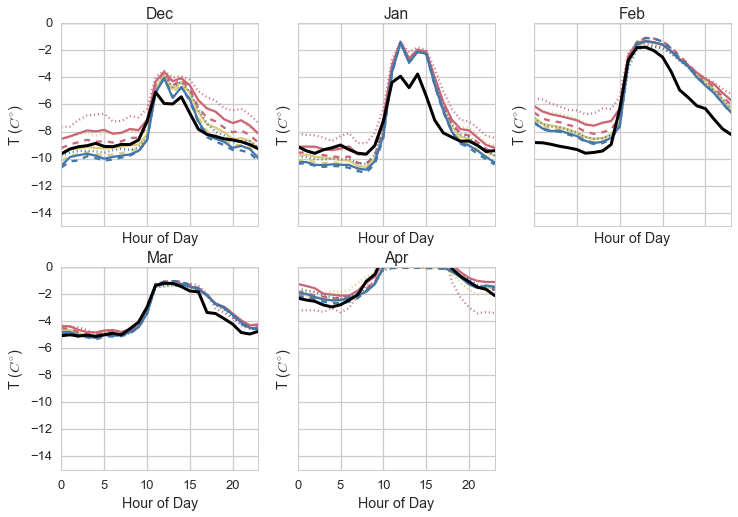

In [15]:
# --------------------------------------------------------------------------------------------------------------------
# Layers
fig, axes = plt.subplots(2, 3, figsize= (12, 8), sharey='row', sharex='col')
axes = axes.flatten()
tempDS = {}
for n in layerExp:
    tempDS[n] = layerExp[n]
    tempDS[n]['scalarSurfaceTemp'] = layerExp[n]['scalarSurfaceTemp'].where((CDP.SP == 1)
                                                                            & (tempDS[n]['scalarSWE'] > 0))
months = [12, 1, 2, 3, 4]
monthLabels = {12: 'Dec', 1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr'}
for n, m in enumerate(months):
    ax = axes[n]
    criteria = CDP['time.month'] == m
    evalDiurnalTs_Criteria(ax, tempDS, CDP, criteria, layerExpLabel, layerExpLineStyle, layerExpColor)
    ax.legend_.remove()
    ax.set_title(monthLabels[m])
axes[5].set_visible(False)

# os.chdir(dirPrint)
# fig.savefig('ModTsfc.WSC17.DiurnalTs_All.pdf')
# fig.savefig('ModTsfc.WSC17.DiurnalTs_All.png')

# --------------------------------------------------------------------------------------------------------------------
# Longwave Bias
fig, axes = plt.subplots(2, 3, figsize= (12, 8), sharey='row', sharex='col')
axes = axes.flatten()
tempDS = {}
for n in biasLW:
    tempDS[n] = biasLW[n]
    tempDS[n]['scalarSurfaceTemp'] = biasLW[n]['scalarSurfaceTemp'].where((CDP.SP == 1)
                                                                            & (tempDS[n]['scalarSWE'] > 0))
months = [12, 1, 2, 3, 4]
monthLabels = {12: 'Dec', 1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr'}
for n, m in enumerate(months):
    ax = axes[n]
    criteria = CDP['time.month'] == m
    evalDiurnalTs_Criteria(ax, tempDS, CDP, criteria, biasLWLabel, biasLWLineStyle, biasLWColor)
    ax.legend_.remove()
    ax.set_title(monthLabels[m])
axes[5].set_visible(False)

# os.chdir(dirPrint)
# fig.savefig('ModTsfc.WSC17.DiurnalTs_All.pdf')
# fig.savefig('ModTsfc.WSC17.DiurnalTs_All.png')

# --------------------------------------------------------------------------------------------------------------------
# Thermal Conductivity
fig, axes = plt.subplots(2, 3, figsize= (12, 8), sharey='row', sharex='col')
axes = axes.flatten()
tempDS = {}
for n in thCond:
    tempDS[n] = thCond[n]
    tempDS[n]['scalarSurfaceTemp'] = thCond[n]['scalarSurfaceTemp'].where((CDP.SP == 1)
                                                                            & (tempDS[n]['scalarSWE'] > 0))
months = [12, 1, 2, 3, 4]
monthLabels = {12: 'Dec', 1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr'}
for n, m in enumerate(months):
    ax = axes[n]
    criteria = CDP['time.month'] == m
    evalDiurnalTs_Criteria(ax, tempDS, CDP, criteria, thCondLabel, thCondLineStyle, thCondColor)
    ax.legend_.remove()
    ax.set_title(monthLabels[m])
axes[5].set_visible(False)

# os.chdir(dirPrint)
# fig.savefig('ModTsfc.WSC17.DiurnalTs_All.pdf')
# fig.savefig('ModTsfc.WSC17.DiurnalTs_All.png')

# --------------------------------------------------------------------------------------------------------------------
# Stability
fig, axes = plt.subplots(2, 3, figsize= (12, 8), sharey='row', sharex='col')
axes = axes.flatten()
tempDS = {}
for n in stab:
    tempDS[n] = stab[n]
    tempDS[n]['scalarSurfaceTemp'] = stab[n]['scalarSurfaceTemp'].where((CDP.SP == 1)
                                                                            & (tempDS[n]['scalarSWE'] > 0))
months = [12, 1, 2, 3, 4]
monthLabels = {12: 'Dec', 1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr'}
for n, m in enumerate(months):
    ax = axes[n]
    criteria = CDP['time.month'] == m
    evalDiurnalTs_Criteria(ax, tempDS, CDP, criteria, stabLabel, stabLineStyle, stabColor)
    ax.legend_.remove()
    ax.set_title(monthLabels[m])
axes[5].set_visible(False)

# os.chdir(dirPrint)
# fig.savefig('ModTsfc.WSC17.DiurnalTs_All.pdf')
# fig.savefig('ModTsfc.WSC17.DiurnalTs_All.png')